<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/Autoencoders/Stacked%20Autoencoders/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

## Transform

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

## Load Data

In [3]:
# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
classes = ('zero', 'one', 'two', 'three','four', 'five', 'six', 'seven', 'eight', 'nine')

## Batching

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

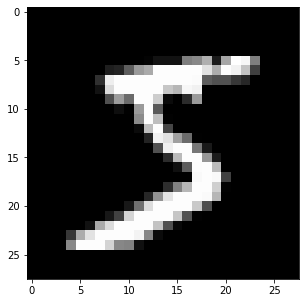

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Configure GPU

In [8]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
gpu = torch.device('cuda:0')

1
Tesla P100-PCIE-16GB


## Model Class

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# initialize the NN
model = autoencoder()
model = model.to(gpu)
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
import copy

In [13]:
print(model.encoder[0])

Linear(in_features=784, out_features=400, bias=True)


In [14]:
init_weights = copy.deepcopy(model.encoder[0].weight.data)

In [15]:
# specify loss function
criterion = nn.MSELoss()
learning_rate = 0.98

## Train The Model

In [16]:
# number of epochs to train the model
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        images = images.to(gpu)

        # zeroes the gradient buffers of all parameters
        model.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # weight = weight - learning_rate * gradient (Update Weights)
        #optimizer.step()
        for f in model.parameters():
          f.data.sub_(f.grad.data * learning_rate)
        
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
print('Finished Training')

Epoch: 1 	Training Loss: 1.167335
Epoch: 2 	Training Loss: 0.702814
Epoch: 3 	Training Loss: 0.545346
Epoch: 4 	Training Loss: 0.449486
Epoch: 5 	Training Loss: 0.384180
Epoch: 6 	Training Loss: 0.337035
Epoch: 7 	Training Loss: 0.301686
Epoch: 8 	Training Loss: 0.274168
Epoch: 9 	Training Loss: 0.252088
Epoch: 10 	Training Loss: 0.233977
Finished Training


## Stacking Layers

In [17]:
# Adding New Layer (Stacking)
model.encoder.add_module('New_Encoder_Layer', nn.Sequential(nn.Linear(400, 256),nn.Tanh()))
model.encoder.add_module('New_Decoder_Layer', nn.Sequential(nn.Linear(256, 400),nn.Tanh()))
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (New_Encoder_Layer): Sequential(
      (0): Linear(in_features=400, out_features=256, bias=True)
      (1): Tanh()
    )
    (New_Decoder_Layer): Sequential(
      (0): Linear(in_features=256, out_features=400, bias=True)
      (1): Tanh()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


In [18]:
model = model.to(gpu)

## Train The model

In [19]:
# number of epochs to train the model
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        images = images.to(gpu)

        # zeroes the gradient buffers of all parameters
        model.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # weight = weight - learning_rate * gradient (Update Weights)
        #optimizer.step()
        for f in model.parameters():
          f.data.sub_(f.grad.data * learning_rate)
        
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
print('Finished Training')

Epoch: 1 	Training Loss: 0.422850
Epoch: 2 	Training Loss: 0.277196
Epoch: 3 	Training Loss: 0.248446
Epoch: 4 	Training Loss: 0.231718
Epoch: 5 	Training Loss: 0.219813
Epoch: 6 	Training Loss: 0.210553
Epoch: 7 	Training Loss: 0.202739
Epoch: 8 	Training Loss: 0.195729
Epoch: 9 	Training Loss: 0.189298
Epoch: 10 	Training Loss: 0.183447
Finished Training


## Modifying the autoencoder for classification

In [20]:
print(*list(model.children())[:-1])

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): Tanh()
  (New_Encoder_Layer): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): Tanh()
  )
  (New_Decoder_Layer): Sequential(
    (0): Linear(in_features=256, out_features=400, bias=True)
    (1): Tanh()
  )
)


In [21]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(model.children())[:-1])
model = new_classifier
print(model)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (New_Encoder_Layer): Sequential(
      (0): Linear(in_features=400, out_features=256, bias=True)
      (1): Tanh()
    )
    (New_Decoder_Layer): Sequential(
      (0): Linear(in_features=256, out_features=400, bias=True)
      (1): Tanh()
    )
  )
)


In [22]:
print(*list(model[0].children())[:-1])

Linear(in_features=784, out_features=400, bias=True) Tanh() Sequential(
  (0): Linear(in_features=400, out_features=256, bias=True)
  (1): Tanh()
)


In [23]:
new_classifier = nn.Sequential(*list(model[0].children())[:-1])
model = new_classifier
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): Tanh()
  (2): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): Tanh()
  )
)


In [24]:
# Adding linear layer for 10-class classification problem
model.add_module('classifier', nn.Sequential(nn.Linear(256, 10),nn.LogSoftmax(dim=1)))
model = model.to(gpu)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): Tanh()
  (2): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


## Train Classifier

In [25]:
epochs = 10
learning_rate = 0.1
criterion = nn.NLLLoss()

for epoch in range(epochs):  # loop over the dataset multiple times

    runningLoss = 0.0
    for data in train_loader:
        # get the inputs
        inputs, labels = data        
        inputs, labels = inputs.view(-1, 28*28).to(gpu), labels.to(gpu)
        model.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = model(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        # weight = weight - learning_rate * gradient (Update Weights)
        for f in model.parameters():
            f.data.sub_(f.grad.data * learning_rate)
        runningLoss += loss.item()
        correct = 0
        total = 0
        
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.view(-1, 28*28).to(gpu), labels.to(gpu)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    m = 60000/batch_size
    print('At Epoch : %d / %d  ;  Train Error : %f ;Test Accuracy : %f '%(epoch + 1,epochs, runningLoss/m,100 * correct /float(total)))
print('Finished Training')

At Epoch : 1 / 10  ;  Train Error : 0.246570 ;Test Accuracy : 95.349998 
At Epoch : 2 / 10  ;  Train Error : 0.110255 ;Test Accuracy : 96.549995 
At Epoch : 3 / 10  ;  Train Error : 0.073162 ;Test Accuracy : 96.959999 
At Epoch : 4 / 10  ;  Train Error : 0.052121 ;Test Accuracy : 97.139999 
At Epoch : 5 / 10  ;  Train Error : 0.037765 ;Test Accuracy : 97.239998 
At Epoch : 6 / 10  ;  Train Error : 0.027022 ;Test Accuracy : 97.509995 
At Epoch : 7 / 10  ;  Train Error : 0.018792 ;Test Accuracy : 97.750000 
At Epoch : 8 / 10  ;  Train Error : 0.013279 ;Test Accuracy : 97.849998 
At Epoch : 9 / 10  ;  Train Error : 0.009423 ;Test Accuracy : 97.869995 
At Epoch : 10 / 10  ;  Train Error : 0.006842 ;Test Accuracy : 97.829994 
Finished Training


## Performance of different Classes

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = model(images.view(-1, 28*28).to(gpu))
        _, predicted = torch.max(outputs.data, 1)
        
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * float(class_correct[i]) / float(class_total[i])))

Accuracy of  zero : 99.183673 %
Accuracy of   one : 99.207048 %
Accuracy of   two : 98.255814 %
Accuracy of three : 97.821782 %
Accuracy of  four : 98.574338 %
Accuracy of  five : 98.430493 %
Accuracy of   six : 97.181628 %
Accuracy of seven : 95.914397 %
Accuracy of eight : 97.433265 %
Accuracy of  nine : 96.233895 %
